In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from src import orbits as orb
from Utilities import sections as sec
from scipy.integrate import odeint
import os
from Utilities.basic_units import radians

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

<Figure size 800x600 with 0 Axes>

In [15]:
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
check = 'HiRes' # 'Low' or 'HiRes' or 'Res20'
folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}'
snap = '199'
path = f'TDE/{folder}{check}/{snap}'
saving_path = f'Figs/{folder}/{check}'
print(f'We are in: {path}, \nWe save in: {saving_path}')
is_tde = True

Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp
apo = Rt**2 / Rstar #2 * Rt * (Mbh/mstar)**(1/3)

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2

We are in: TDE/R0.47M0.5BH10000beta1S60n1.5HiRes/199, 
We save in: Figs/R0.47M0.5BH10000beta1S60n1.5/HiRes


In [16]:
def Nick_fall(z0, theta, b = beta):
    zE = 1/b * 2*np.sin(theta) / (1+np.cos(theta))
    zF = 1/b * 2*np.cos(theta) / (1+np.cos(theta))
    E = -z0 * np.sqrt(b-1)
    F = z0
    return E*zE + F*zF 

Load data

In [17]:
data = make_tree(path, snap, is_tde, energy = False)

R = np.sqrt(data.X**2 + data.Y**2 + data.Z**2)
THETA, RADIUS_cyl = orb.to_cylindric(data.X, data.Y)
V = np.sqrt(data.VX**2 + data.VY**2 + data.VZ**2)
dim_cell = data.Vol**(1/3) # according to Elad
tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

days after disruption: 1.9329137948294375 // t_fall: 2.5777261297507925 // sim_time: 104.84690293887694


In [18]:
theta_lim = 3/4 * np.pi
step = 0.1
theta_params = [-theta_lim, theta_lim, step]
theta_arr = np.arange(*theta_params)

# Cross section at midplane
midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, VX_midplane, VY_midplane, VZ_midplane, Mass_midplane, Den_midplane, Press_midplane, Temp_midplane = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.VX, data.VY, data.VZ, data.Mass, data.Den, data.Press, data.Temp], midplane)

In [19]:
z_arr = np.arange(-1, 1, .2)
free_fall = []
for i,z0 in enumerate(z_arr):
    z = Nick_fall(z0, theta_arr)
    free_fall.append(z)

Text(0.5, 0, '$\\theta$')

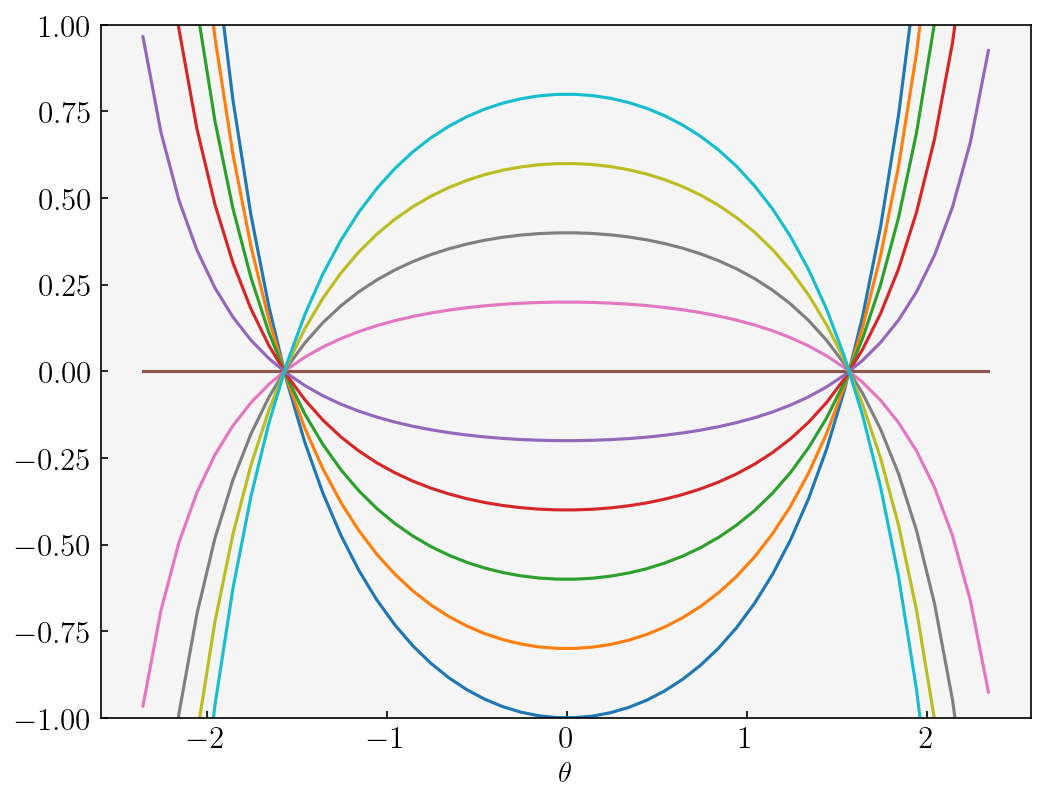

In [20]:
for i in range(len(z_arr)):
    plt.plot(theta_arr, free_fall[i])
plt.ylim(-1,1)
plt.xlabel(r'$\theta$', fontsize = 14)